In [67]:
import pandas as pd
import numpy as np

# Data pre-processing
import nltk
from nltk.stem import WordNetLemmatizer

# List of stop words used for data pre-processing
from stop_words_list import stop_words_list
from nltk.corpus import stopwords

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Topics modelling
from gsdmm.gsdmm.mgp import MovieGroupProcess

In [68]:
# List of available creators: "MKBHD", "Jonathan Morrison", "Unbox Therapy", "Chris Stuckman", "Jeremy Jahns", "Channel Awesome", "James Charles", "NikkieTutorials", "sophdoeslife"

creator = "NikkieTutorials"
output_df = pd.read_excel(f"../comments_spreadsheets/extracted_comments_{creator}.xlsx")

In [69]:
duplicates = output_df[output_df.duplicated(("Comments"))]
print ("Count of duplicate comments in dataframe"
, duplicates.shape[0])

print ("Count of unique comments in dataframe"
, output_df.shape[0] - duplicates.shape[0])

# Remove duplicated comments from dataset
unique_df = output_df.drop_duplicates(subset=["Comments"], keep='first')
df = unique_df.reset_index()

# Removes line return "\n"
df = df.replace(r'\n',' ', regex=True)

display(df)

Count of duplicate comments in dataframe 24
Count of unique comments in dataframe 1976


,index,Video ID,Comment ID,Comments
0,0,-qn_cTHvfOY,Ugxgr1vjrtDWkJrnrCB4AaABAg,*WHAT'S UR FAVORITE ARIANA GRANDE SONG?*
1,1,-qn_cTHvfOY,UgwJUsXgC2RHBVD7KXB4AaABAg,I don’t think people realize that Ari is usual...
2,2,-qn_cTHvfOY,UgwPQIeM5WdRf3dAZoB4AaABAg,Daily reminder: If you are a arianator it is o...
3,3,-qn_cTHvfOY,UgxNipi4J08dI02k53x4AaABAg,I’m with you on the packaging. It reminds me o...
4,4,-qn_cTHvfOY,Ugy02sG4COz5OIQt-GN4AaABAg,The only thing I have to say is that liquid ey...
...,...,...,...,...
1971,1995,-qn_cTHvfOY,UgzRcHtontnI6SEW7CZ4AaABAg,"It all looks white label'd products , standard..."
1972,1996,-qn_cTHvfOY,UgxtOZByqxDvlkdP1cZ4AaABAg,The product seems like ELF products.
1973,1997,-qn_cTHvfOY,UgxM6NIy4X3mqgU-oed4AaABAg,looks like little girl dollarstore makeup :(
1974,1998,-qn_cTHvfOY,UgwP_U9FMCuOTy8Tejx4AaABAg,I think that she care about product and not pa...


# Sentiment Analysis

In [70]:
sentimentAnalyser = SentimentIntensityAnalyzer()
sentimentScoreList = []
sentimentLabelList = []

for i in df["Comments"].values.tolist():
    sentimentScore = sentimentAnalyser.polarity_scores(i)

    if sentimentScore['compound'] >= 0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Positive')
    elif sentimentScore['compound'] > -0.05 and sentimentScore['compound'] < 0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Neutral')
    elif sentimentScore['compound'] <= -0.05:
        sentimentScoreList.append(sentimentScore['compound'])
        sentimentLabelList.append('Negative')

df["Sentiment"] = sentimentLabelList
df["Sentiment Score"] = sentimentScoreList

display(df.head(10))

,index,Video ID,Comment ID,Comments,Sentiment,Sentiment Score
0,0,-qn_cTHvfOY,Ugxgr1vjrtDWkJrnrCB4AaABAg,*WHAT'S UR FAVORITE ARIANA GRANDE SONG?*,Positive,0.4588
1,1,-qn_cTHvfOY,UgwJUsXgC2RHBVD7KXB4AaABAg,I don’t think people realize that Ari is usual...,Positive,0.8591
2,2,-qn_cTHvfOY,UgwPQIeM5WdRf3dAZoB4AaABAg,Daily reminder: If you are a arianator it is o...,Positive,0.5368
3,3,-qn_cTHvfOY,UgxNipi4J08dI02k53x4AaABAg,I’m with you on the packaging. It reminds me o...,Positive,0.8024
4,4,-qn_cTHvfOY,Ugy02sG4COz5OIQt-GN4AaABAg,The only thing I have to say is that liquid ey...,Positive,0.1280
5,5,-qn_cTHvfOY,UgwLcmNISNTFKJix9dl4AaABAg,Recycled packaging doesnt necessarily have to ...,Neutral,0.0000
6,6,-qn_cTHvfOY,UgzyBL8LnSbiRDHgqpJ4AaABAg,the packaging is “simplistic” because the prod...,Positive,0.7964
7,7,-qn_cTHvfOY,UgxT7hUCrcqCxAIfDk94AaABAg,I love how sweet you’re even with being honest...,Positive,0.9697
8,8,-qn_cTHvfOY,UgzU-xBPjIWk43D8oUZ4AaABAg,I really think a lot of celebrities are coming...,Positive,0.8910
9,9,-qn_cTHvfOY,Ugw1FPGLauT05yRHE1Z4AaABAg,I feel like nikkie is the perfect person to re...,Positive,0.9353


In [71]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

# Convert case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string
# Lowercase all the letters
df['lower'] = df['Comments'].str.lower()

# Remove punctuations
df['punctuation_removed'] = df['lower'].str.replace("'", '', regex=True).str.replace('[^\w\s]', ' ', regex=True)

# Remove numbers
df['numbers_removed'] = df['punctuation_removed'].str.replace(" \d+", " ", regex=True)

# Remove extra whitespace
df['extra_spaces_removed'] = df['numbers_removed'].str.replace(' +', ' ', regex=True).str.strip()

# Tokenise
df['tokenised'] = df.apply(lambda row: nltk.word_tokenize(row['extra_spaces_removed']), axis=1)

# Stop words removal
# Initiate stopwords from nltk
stop_words = stopwords.words('english')

# Add additional missing terms
stop_words.extend(stop_words_list)

# Remove stopwords
df['removed_stopwords'] = df['tokenised'].apply(lambda x: [item for item in x if item not in stop_words])

docs = []

for token in df.removed_stopwords:
    docs.append(token)

display(df.head(10))

,index,Video ID,Comment ID,Comments,Sentiment,Sentiment Score,lower,punctuation_removed,numbers_removed,extra_spaces_removed,tokenised,removed_stopwords
0,0,-qn_cTHvfOY,Ugxgr1vjrtDWkJrnrCB4AaABAg,*WHAT'S UR FAVORITE ARIANA GRANDE SONG?*,Positive,0.4588,*what's ur favorite ariana grande song?*,whats ur favorite ariana grande song,whats ur favorite ariana grande song,whats ur favorite ariana grande song,"[whats, ur, favorite, ariana, grande, song]","[ur, favorite, ariana, grande, song]"
1,1,-qn_cTHvfOY,UgwJUsXgC2RHBVD7KXB4AaABAg,I don’t think people realize that Ari is usual...,Positive,0.8591,i don’t think people realize that ari is usual...,i don t think people realize that ari is usual...,i don t think people realize that ari is usual...,i don t think people realize that ari is usual...,"[i, don, t, think, people, realize, that, ari,...","[people, realize, ari, simple, minimal, makeup..."
2,2,-qn_cTHvfOY,UgwPQIeM5WdRf3dAZoB4AaABAg,Daily reminder: If you are a arianator it is o...,Positive,0.5368,daily reminder: if you are a arianator it is o...,daily reminder if you are a arianator it is o...,daily reminder if you are a arianator it is o...,daily reminder if you are a arianator it is ok...,"[daily, reminder, if, you, are, a, arianator, ...","[daily, reminder, arianator, honest, real, agr..."
3,3,-qn_cTHvfOY,UgxNipi4J08dI02k53x4AaABAg,I’m with you on the packaging. It reminds me o...,Positive,0.8024,i’m with you on the packaging. it reminds me o...,i m with you on the packaging it reminds me o...,i m with you on the packaging it reminds me o...,i m with you on the packaging it reminds me of...,"[i, m, with, you, on, the, packaging, it, remi...","[packaging, reminds, pharmacy, eyeshadows, mom..."
4,4,-qn_cTHvfOY,Ugy02sG4COz5OIQt-GN4AaABAg,The only thing I have to say is that liquid ey...,Positive,0.1280,the only thing i have to say is that liquid ey...,the only thing i have to say is that liquid ey...,the only thing i have to say is that liquid ey...,the only thing i have to say is that liquid ey...,"[the, only, thing, i, have, to, say, is, that,...","[thing, liquid, eyeshadow, supposed, applied, ..."
5,5,-qn_cTHvfOY,UgwLcmNISNTFKJix9dl4AaABAg,Recycled packaging doesnt necessarily have to ...,Neutral,0.0000,recycled packaging doesnt necessarily have to ...,recycled packaging doesnt necessarily have to ...,recycled packaging doesnt necessarily have to ...,recycled packaging doesnt necessarily have to ...,"[recycled, packaging, doesnt, necessarily, hav...","[recycled, packaging, cheap, packaging, price,..."
6,6,-qn_cTHvfOY,UgzyBL8LnSbiRDHgqpJ4AaABAg,the packaging is “simplistic” because the prod...,Positive,0.7964,the packaging is “simplistic” because the prod...,the packaging is simplistic because the prod...,the packaging is simplistic because the prod...,the packaging is simplistic because the produc...,"[the, packaging, is, simplistic, because, the,...","[packaging, simplistic, products, recycled, pe..."
7,7,-qn_cTHvfOY,UgxT7hUCrcqCxAIfDk94AaABAg,I love how sweet you’re even with being honest...,Positive,0.9697,i love how sweet you’re even with being honest...,i love how sweet you re even with being honest...,i love how sweet you re even with being honest...,i love how sweet you re even with being honest...,"[i, love, how, sweet, you, re, even, with, bei...","[sweet, honest, needed, generation, packaging,..."
8,8,-qn_cTHvfOY,UgzU-xBPjIWk43D8oUZ4AaABAg,I really think a lot of celebrities are coming...,Positive,0.8910,i really think a lot of celebrities are coming...,i really think a lot of celebrities are coming...,i really think a lot of celebrities are coming...,i really think a lot of celebrities are coming...,"[i, really, think, a, lot, of, celebrities, ar...","[lot, celebrities, coming, makeup, skin, care,..."
9,9,-qn_cTHvfOY,Ugw1FPGLauT05yRHE1Z4AaABAg,I feel like nikkie is the perfect person to re...,Positive,0.9353,i feel like nikkie is the perfect person to re...,i feel like nikkie is the perfect person to re...,i feel

In [72]:
mgp = MovieGroupProcess(K=3, alpha=0.1, beta=1, n_iters=30)

vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

mgp_output = mgp.fit(docs, n_terms)

In stage 0: transferred 1164 clusters with 3 clusters populated
In stage 1: transferred 880 clusters with 3 clusters populated
In stage 2: transferred 736 clusters with 3 clusters populated
In stage 3: transferred 574 clusters with 3 clusters populated
In stage 4: transferred 445 clusters with 3 clusters populated
In stage 5: transferred 426 clusters with 3 clusters populated
In stage 6: transferred 392 clusters with 3 clusters populated
In stage 7: transferred 373 clusters with 3 clusters populated
In stage 8: transferred 379 clusters with 3 clusters populated
In stage 9: transferred 359 clusters with 3 clusters populated
In stage 10: transferred 380 clusters with 3 clusters populated
In stage 11: transferred 391 clusters with 3 clusters populated
In stage 12: transferred 356 clusters with 3 clusters populated
In stage 13: transferred 353 clusters with 3 clusters populated
In stage 14: transferred 364 clusters with 3 clusters populated
In stage 15: transferred 364 clusters with 3 clus

In [73]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

Number of documents per topic : [1424  531   21]


In [74]:
top_index = doc_count.argsort()[-15:][::-1]
print('Indices of most important clusters (by number of docs inside):', top_index)

Indices of most important clusters (by number of docs inside): [0 1 2]


In [75]:
# Returns the top words present in each topic cluster.
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print('-'*120)

In [76]:
# Show the top 7 words in term frequency for each cluster
top_words(mgp.cluster_word_distribution, top_index, 7)

Cluster 0 : [('packaging', 427), ('makeup', 212), ('products', 117), ('mascara', 110), ('lipstick', 108), ('lashes', 108), ('cheap', 106)]
------------------------------------------------------------------------------------------------------------------------
Cluster 1 : [('nikkie', 96), ('makeup', 59), ('video', 53), ('nikki', 43), ('honest', 32), ('review', 32), ('watching', 27)]
------------------------------------------------------------------------------------------------------------------------
Cluster 2 : [('de', 11), ('eu', 6), ('je', 6), ('ik', 5), ('het', 5), ('en', 4), ('dat', 4)]
------------------------------------------------------------------------------------------------------------------------


In [77]:
topic_dict = {}
topic_names = ['Topic #1', 'Topic #2', 'Topic #3']
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i]

In [78]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]

# Create a dataframe with the original text and its assigned topic.
def create_topics_dataframe(data_text=df.Comments,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, stem_text=docs):
    result = pd.DataFrame(columns=['topic'])
    for i, text in enumerate(data_text):
        prob = mgp.choose_best_label(stem_text[i])
        if prob[1] >= threshold:
            result.at[i, 'topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'topic'] = 'Other'
    return result

In [79]:
dfx = create_topics_dataframe(data_text=df.Comments,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, stem_text=docs)
dfx.topic.value_counts(dropna=False)

Topic #1    1482
Topic #2     476
Topic #3      18
Name: topic, dtype: int64

In [80]:
df = pd.merge(df, dfx, left_index = True, right_index = True, how = 'outer')
display(df)

,index,Video ID,Comment ID,Comments,Sentiment,Sentiment Score,lower,punctuation_removed,numbers_removed,extra_spaces_removed,tokenised,removed_stopwords,topic
0,0,-qn_cTHvfOY,Ugxgr1vjrtDWkJrnrCB4AaABAg,*WHAT'S UR FAVORITE ARIANA GRANDE SONG?*,Positive,0.4588,*what's ur favorite ariana grande song?*,whats ur favorite ariana grande song,whats ur favorite ariana grande song,whats ur favorite ariana grande song,"[whats, ur, favorite, ariana, grande, song]","[ur, favorite, ariana, grande, song]",Topic #2
1,1,-qn_cTHvfOY,UgwJUsXgC2RHBVD7KXB4AaABAg,I don’t think people realize that Ari is usual...,Positive,0.8591,i don’t think people realize that ari is usual...,i don t think people realize that ari is usual...,i don t think people realize that ari is usual...,i don t think people realize that ari is usual...,"[i, don, t, think, people, realize, that, ari,...","[people, realize, ari, simple, minimal, makeup...",Topic #1
2,2,-qn_cTHvfOY,UgwPQIeM5WdRf3dAZoB4AaABAg,Daily reminder: If you are a arianator it is o...,Positive,0.5368,daily reminder: if you are a arianator it is o...,daily reminder if you are a arianator it is o...,daily reminder if you are a arianator it is o...,daily reminder if you are a arianator it is ok...,"[daily, reminder, if, you, are, a, arianator, ...","[daily, reminder, arianator, honest, real, agr...",Topic #2
3,3,-qn_cTHvfOY,UgxNipi4J08dI02k53x4AaABAg,I’m with you on the packaging. It reminds me o...,Positive,0.8024,i’m with you on the packaging. it reminds me o...,i m with you on the packaging it reminds me o...,i m with you on the packaging it reminds me o...,i m with you on the packaging it reminds me of...,"[i, m, with, you, on, the, packaging, it, remi...","[packaging, reminds, pharmacy, eyeshadows, mom...",Topic #1
4,4,-qn_cTHvfOY,Ugy02sG4COz5OIQt-GN4AaABAg,The only thing I have to say is that liquid ey...,Positive,0.1280,the only thing i have to say is that liquid ey...,the only thing i have to say is that liquid ey...,the only thing i have to say is that liquid ey...,the only thing i have to say is that liquid ey...,"[the, only, thing, i, have, to, say, is, that,...","[thing, liquid, eyeshadow, supposed, applied, ...",Topic #1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,1995,-qn_cTHvfOY,UgzRcHtontnI6SEW7CZ4AaABAg,"It all looks white label'd products , standard...",Neutral,0.0000,"it all looks white label'd products , standard...",it all looks white labeld products standard ...,it all looks white labeld products standard ...,it all looks white labeld products standard an...,"[it, all, looks, white, labeld, products, stan...","[white, labeld, products, standard, cheap, cel...",Topic #1
1972,1996,-qn_cTHvfOY,UgxtOZByqxDvlkdP1cZ4AaABAg,The product seems like ELF products.,Positive,0.3612,the product seems like elf products.,the product seems like elf products,the product seems like elf products,the product seems like elf products,"[the, product, seems, like, elf, products]","[product, elf, products]",Topic #1
1973,1997,-qn_cTHvfOY,UgxM6NIy4X3mqgU-oed4AaABAg,looks like little girl dollarstore makeup :(,Negative,-0.1027,looks like little girl dollarstore makeup :(,looks like little girl dollarstore makeup,looks like little girl dollarstore makeup,looks like little girl dollarstore makeup,"[looks, like, little, girl, dollarstore, makeup]","[girl, dollarstore, makeup]",Topic #1
1974,1998,-qn_cTHvfOY,UgwP_U9FMCuOTy8Tejx4AaABAg,I think that she care about product and not pa...,Positive,0.7152,i think that she care about product and not pa...,i think that she care about product and not pa...,i think that she care about product and not pa...,i think that she care about product and not pa...,"[i, think, that, she, care, about, product, an...","[care, product, package, cheap, fit, evreyone,...",Topic #1


In [81]:
results = df.groupby(['topic', 'Sentiment']).count().reset_index()

graph_results = results[['topic', 'Sentiment', 'Sentiment Score']]
graph_results = graph_results.pivot(index='topic', columns='Sentiment', values='Sentiment Score').reset_index()

graph_results.set_index('topic', inplace=True)

display(graph_results)

Sentiment,Negative,Neutral,Positive
topic,,,
Topic #1,119,218,1145
Topic #2,44,86,346
Topic #3,4,6,8


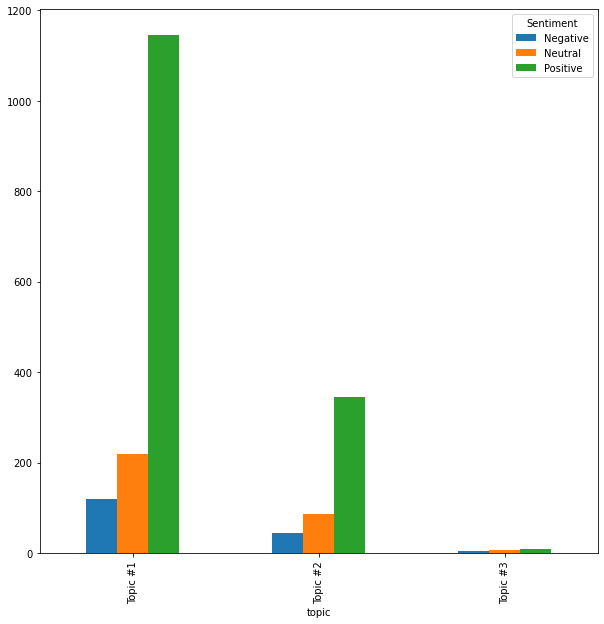

In [82]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))

# Uncomment to save the figure as a png to current directory
# fig.figure.savefig(f'{creator}_absa_gsdmm.png' , bbox_inches='tight')